In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/home/noise/Área de trabalho/credit')

from src.utils_modelling import analisy_univariate, wo_discretize, plot_woe


In [7]:
df = pd.read_csv('/home/noise/Área de trabalho/credit/data/silver/loan_data_2007_2014.csv')

/tmp/ipykernel_267593/4133937538.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/noise/Área de trabalho/credit/data/silver/loan_data_2007_2014.csv')


In [8]:
def clean(value):
    if pd.isna(value):
        return 0
    elif '10+' in value:
        return 10
    elif '<' in value:
        return 0
    else:
        return float(value.split()[0])
    
df['emp_length_int'] = df['emp_length'].apply(clean)

In [9]:
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [10]:
pd.to_datetime('2017-12-01') - df['earliest_cr_line_date'] 

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [11]:
df['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['earliest_cr_line_date']) / np.timedelta64(1, 'm')))

In [12]:
df.loc[:, ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][df['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-23536800.0
1770,Sep-68,2068-09-01,-26693280.0
2799,Sep-64,2064-09-01,-24589440.0
3282,Sep-67,2067-09-01,-26166240.0
3359,Feb-65,2065-02-01,-24809760.0
...,...,...,...
464003,Jan-68,2068-01-01,-26341920.0
464260,Jul-66,2066-07-01,-25551360.0
465100,Oct-67,2067-10-01,-26209440.0
465500,Sep-67,2067-09-01,-26166240.0


In [13]:
df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()

/tmp/ipykernel_267593/3793766548.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mths_since_earliest_cr_line'][df['mths_since_earliest_cr_line'] < 0] = df['mths_since_earliest_cr_line'].max()


In [14]:
min(df['mths_since_earliest_cr_line'])

3199680.0

In [15]:
def clean_term(value):
    if pd.isna(value):
        return 0
    elif ' 36 months' in value:
        return 36
    elif ' 60 months' in value:
        return 60
    else:
        return float(value.split()[0])

In [16]:
df['term_int'] = df['term'].apply(clean_term)

In [17]:
df['issue_d_date'] = pd.to_datetime(df['issue_d'], format = '%b-%y')

In [18]:
df['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01')-df['issue_d_date'])/np.timedelta64(1, 'm')))

In [19]:
threshold = 10
categorical_columns = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() < threshold]
print("Variáveis categóricas confirmadas:", categorical_columns)


Variáveis categóricas confirmadas: ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'initial_list_status', 'application_type']


In [20]:
df_dummies = [
    pd.get_dummies(df['grade'], prefix='grade', prefix_sep=':'),
    pd.get_dummies(df['sub_grade'], prefix='sub_grade', prefix_sep=':'),
    pd.get_dummies(df['home_ownership'], prefix='home_ownership', prefix_sep=':'),
    pd.get_dummies(df['verification_status'], prefix='verification_status', prefix_sep=':'),
    pd.get_dummies(df['loan_status'], prefix='loan_status', prefix_sep=':'),
    pd.get_dummies(df['purpose'], prefix='purpose', prefix_sep=':'),
    pd.get_dummies(df['addr_state'], prefix='addr_state', prefix_sep=':'),
    pd.get_dummies(df['initial_list_status'], prefix='initial_list_status', prefix_sep=':'),

]

In [21]:
df_dummies = pd.concat(df_dummies, axis=1)

In [22]:
df = pd.concat([df, df_dummies], axis=1)

/home/noise/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


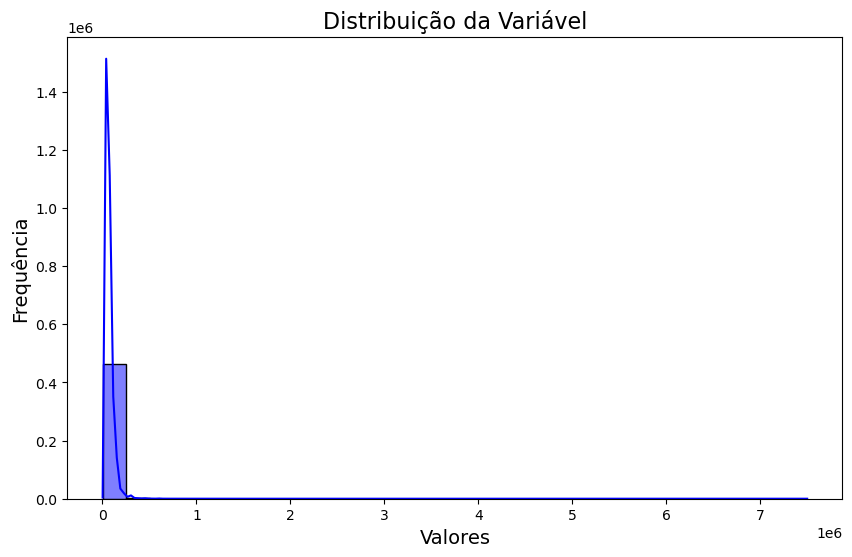

In [23]:
plt.figure(figsize=(10, 6))

# Histograma com KDE (Kernel Density Estimate)
sns.histplot(df['annual_inc'], bins=30, kde=True, color='blue')

# Adicionando título e rótulos
plt.title('Distribuição da Variável', fontsize=16)
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Exibir o gráfico
plt.show()

In [24]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace=True)
df['mths_since_earliest_cr_line'].fillna(0, inplace=True)
df['total_acc'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(0, inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['emp_length_int'].fillna(0, inplace=True)


In [25]:
df['good_bad'] = np.where(df['loan_status'].isin(['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off','Late (31-120 days)']), 0, 1)

In [26]:
df['good_bad']
pd.options.display.max_columns = None


In [27]:
df_input_train, df_input_test, df_target_train, df_target_test = train_test_split(df.drop('good_bad', axis = 1), df['good_bad'], test_size=0.2, random_state=42)


In [28]:
df_inputs_prepr = df_input_train
df_target_prepr = df_target_train

In [29]:
df1 = pd.concat([df_inputs_prepr['grade'], df_target_prepr], axis = 1)


In [30]:
df1.groupby(df1.columns.values[0], as_index= False)[df1.columns.values[1]].count()


,grade,good_bad
0,A,59759
1,B,109730
2,C,100245
3,D,61498
4,E,28612
5,F,10530
6,G,2654


In [31]:
df1.groupby(df1.columns.values[0], as_index= False)[df1.columns.values[1]].mean()


,grade,good_bad
0,A,0.961044
1,B,0.921015
2,C,0.885770
3,D,0.846304
4,E,0.805257
5,F,0.754416
6,G,0.727958


In [32]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].count(),
                 df1.groupby(df1.columns.values[0], as_index=False)[df1.columns.values[1]].mean()], axis = 1)

In [33]:
df_grade = wo_discretize(df_inputs_prepr, 'grade', df_target_prepr)

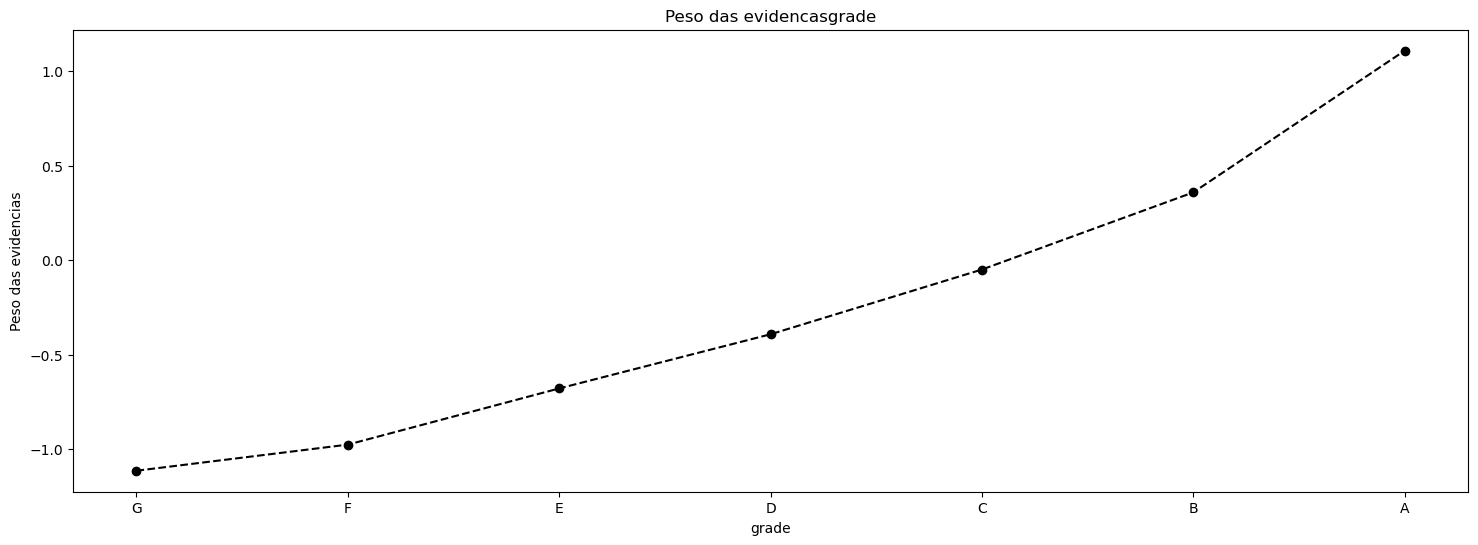

In [34]:
plot_woe(df_grade)

In [35]:
df_home = wo_discretize(df_inputs_prepr, 'home_ownership', df_target_prepr)

In [36]:
df_home

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,woe,diff_prop_good,diff_woe,iv,total_iv
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000328,0.000687,-0.738602,NaN,NaN,0.000265,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000147,-0.363144,0.054380,0.375458,0.000016,inf
2,RENT,150599,0.873870,0.403720,131604.0,18995.0,0.396099,0.465815,-0.162123,0.023870,0.201021,0.011303,inf
3,OWN,33295,0.892536,0.089256,29717.0,3578.0,0.089442,0.087743,0.019170,0.018666,0.181294,0.000033,inf
4,MORTGAGE,188956,0.903835,0.506546,170785.0,18171.0,0.514026,0.445608,0.142834,0.011298,0.123663,0.009772,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.096165,inf,inf,inf


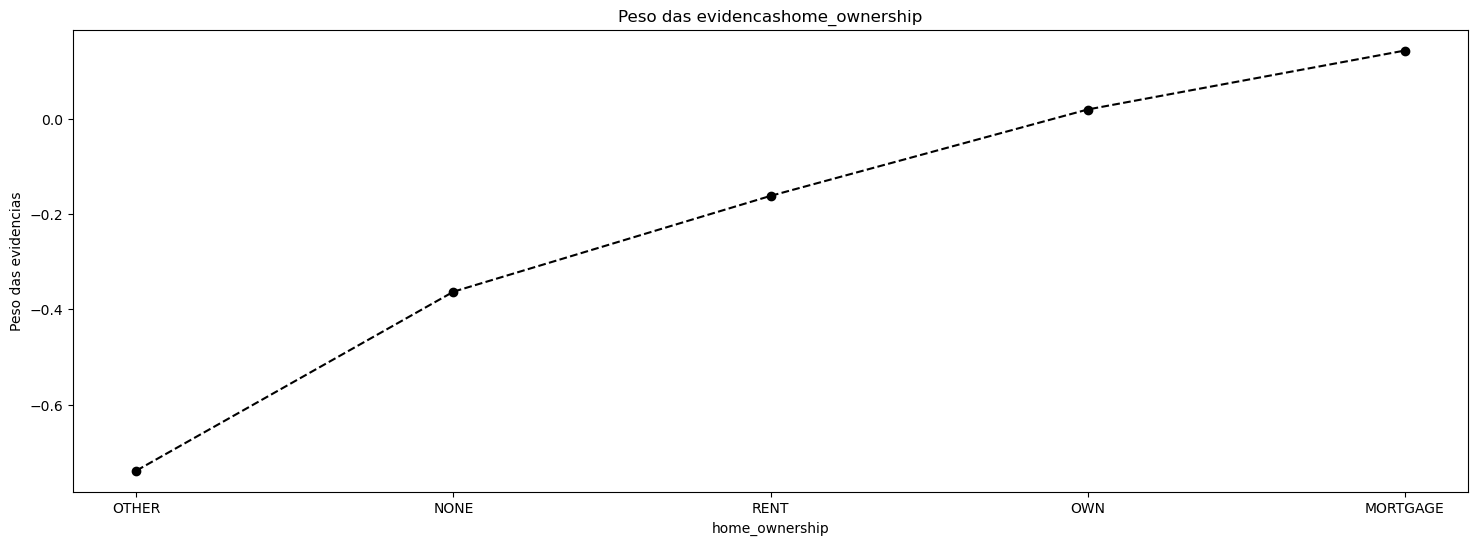

In [37]:
plot_woe(df_home)

In [38]:
df_grade = wo_discretize(df_inputs_prepr, 'purpose', df_target_prepr)

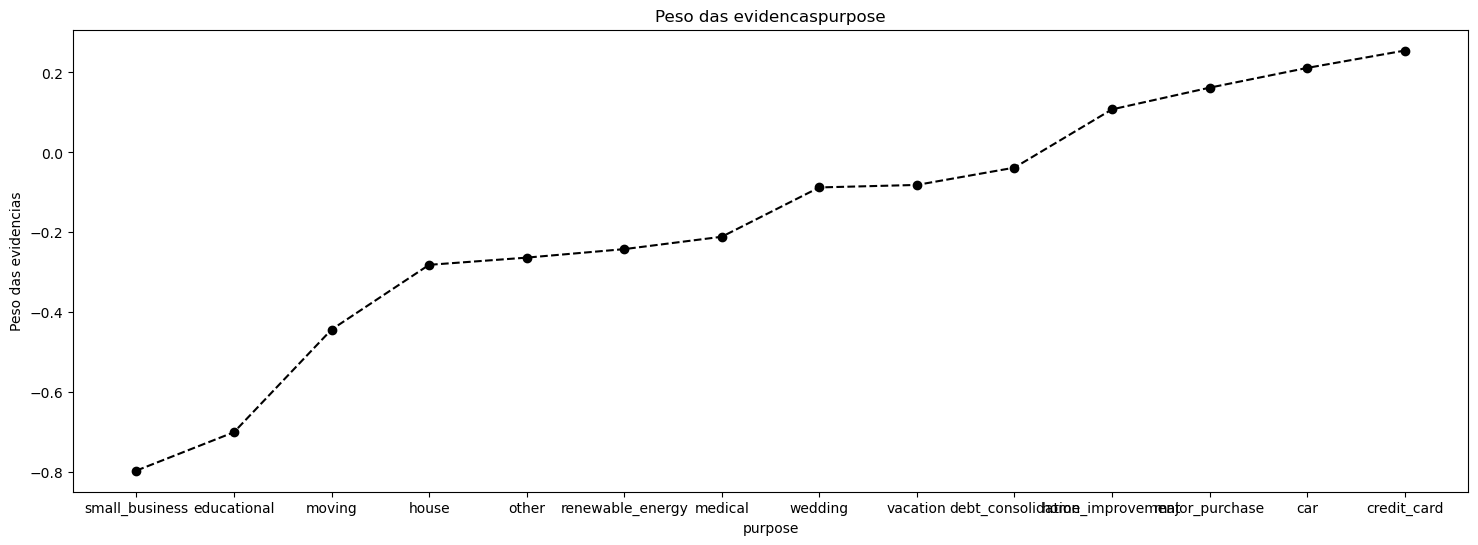

In [39]:
plot_woe(df_grade)

In [40]:
df_status = wo_discretize(df_inputs_prepr, 'verification_status', df_target_prepr)

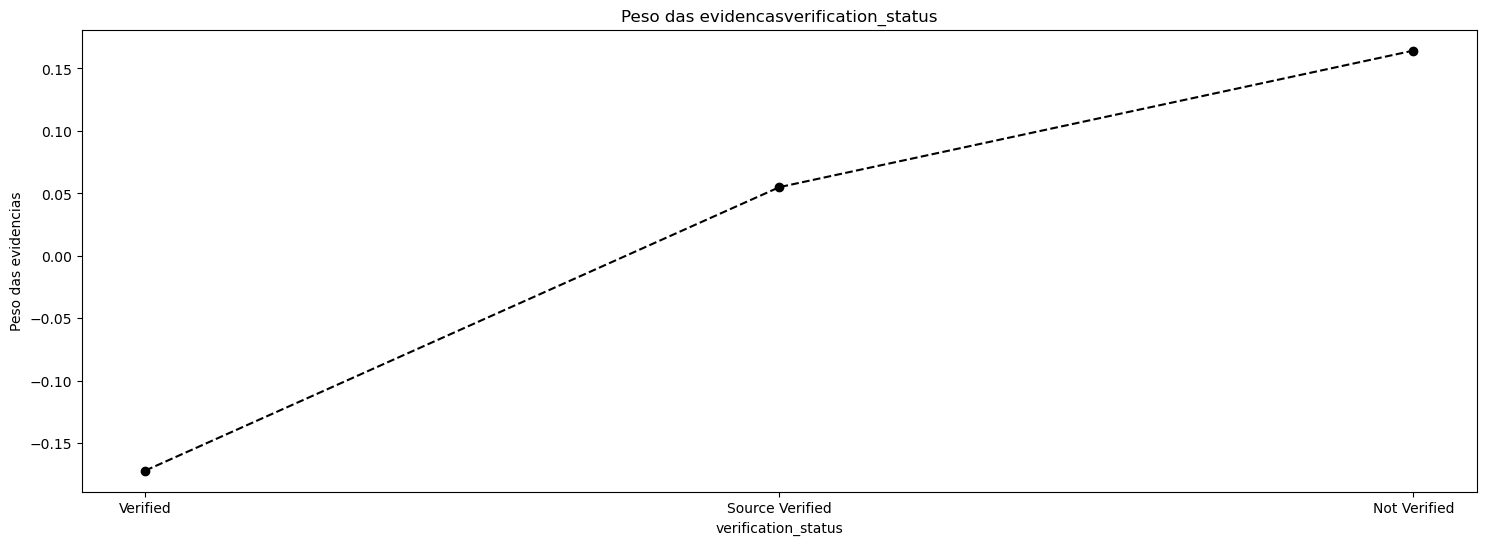

In [41]:
plot_woe(df_status)

In [42]:
df_initial = wo_discretize(df_inputs_prepr, 'initial_list_status', df_target_prepr)

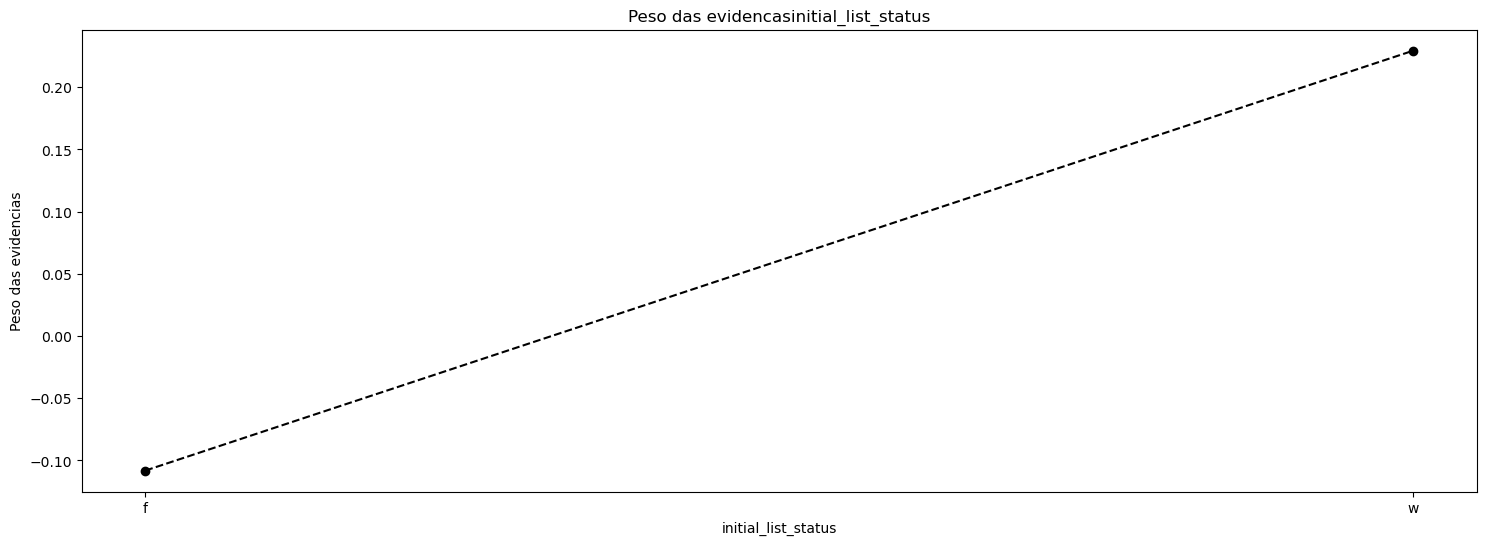

In [43]:
plot_woe(df_initial)

In [44]:
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

In [49]:
df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'], df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'], df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'],df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'],df_inputs_prepr['addr_state:TN'], df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'], df_inputs_prepr['addr_state:MD'],
df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'], df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH'] = sum([df_inputs_prepr['addr_state:AR'],df_inputs_prepr['addr_state:MI'], df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'],df_inputs_prepr['addr_state:MA'], df_inputs_prepr['addr_state:DE'],
df_inputs_prepr['addr_state:SD'], df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'], df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'],df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'], df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'], df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])




In [50]:
df_inputs_prepr['purpose:educ_smb_wedd_ren_en_mov_house'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'], df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])

df_inputs_prepr['purpose:oth_med_vacation'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'], df_inputs_prepr['purpose:vacation']])

df_inputs_prepr['purpose:major_car_home'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'], df_inputs_prepr['purpose:home_improvement']])

In [51]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],  df_inputs_prepr['home_ownership:NONE'],  df_inputs_prepr['home_ownership:ANY']])

In [52]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                      df_inputs_prepr['home_ownership:NONE'],df_inputs_prepr['home_ownership:ANY']])